In [1]:
import matplotlib.pyplot as plt
import lightkurve as lk

import numpy as np

In [2]:
from TESSphomo.tessphomo import TESSTargetPixelModeler
from TESSphomo.tessphomo.mast import retrieve_tess_ffi_cutout_from_mast, get_tic_sources

In [3]:
def write_lc_to_fits_file(data, lc, lc_save_direc='./', overwrite=True):

    targetid = data.tic_id[4:].zfill(12)
    sector = str(data.tpf.sector).zfill(4)
    tpfsize_0, tpfsize_1 = data.tpf.shape[1:]

    fname = 'tessphomo_ffi_lightcurve_sector_'+sector+'_tic_'+targetid+'_cutout_{}'.format(tpfsize_0)+'x{}'.format(tpfsize_1)+'.fits'
  
    lc.write(fname, format='fits', overwrite=overwrite)  
    
    return fname



def plot_lightcurve_and_systematics(lc, **kwargs):


    fig, axes = plt.subplots(5,1, figsize=(10,10))


    axes[0].plot(lc['time'].value, lc['raw_cap_flux'].value, label='CAP', **kwargs)
    axes[0].plot(lc['time'].value, lc['raw_prf_flux'].value, label='PRF', **kwargs)
    
    axes[1].plot(lc['time'].value, lc['cal_cap_flux'], label='CAP', **kwargs)
    axes[1].plot(lc['time'].value, lc['cal_prf_flux'], label='PRF', **kwargs)

    axes[2].plot(lc['time'].value, lc['row_offset'], label='row', **kwargs)
    axes[2].plot(lc['time'].value, lc['col_offset'], label='col', **kwargs)
    
    axes[3].plot(lc['time'].value, lc['zp_flux_scale'], label='Zp Scale', **kwargs)

    axes[4].plot(lc['time'].value, lc['bkg_sapflux'], label='Bkg Flux', **kwargs)



    axes[0].set_ylabel('Raw Flux')
    axes[1].set_ylabel('Cal. Flux')
    axes[2].set_ylabel('pointing\noffset')
    axes[3].set_ylabel('ZP Scale')
    axes[4].set_ylabel('Bkg Flux')

    axes[-1].set_xlabel('Time [BTJD]')

    for ax in axes:
        ax.legend()

    plt.tight_layout()


In [4]:
# Download the necessary TPFs. Note, that you may get some errors if the source is near the edge of the FFI or if the
# source is off of the FFI and instead in the virtual columns. You may have to manually dig in and ignore those sectors, or add in the 
# try :, except: error handling thing to get out of those. I don't have a good wor around built in to the light curve pipeline

# The size of the TPF is probably the most important parameter here. From what I can tell, 25x25 is usually more then adequate, but if 
# the astrometry looks really noisy/inaccurate (e.g., dx>~0.2-0.3), then this should be larger. 15x15 is the absoulte minimum I would go. 
# The bigger you go, the slower everything will be, and you'll be more susceptible to errors caused by the source being too close to the 
# edge of the FFI and weird systematics like being close to a saturated star, which I should fix at some point but haven't done yet. 


ticid = 212957629

all_tpfs = retrieve_tess_ffi_cutout_from_mast(ticid=ticid, cutout_size=(25,25), sector=None)
all_tpfs

TargetPixelFileCollection of 5 objects:
    0: TessTargetPixelFile(TICID: TIC 212957629)
    1: TessTargetPixelFile(TICID: TIC 212957629)
    2: TessTargetPixelFile(TICID: TIC 212957629)
    3: TessTargetPixelFile(TICID: TIC 212957629)
    4: TessTargetPixelFile(TICID: TIC 212957629)

In [5]:
# Define the Input Catalog. This is querying the TIC for all the stars with distances less than  
#   d = sqrt(2) * (TPF size in pixels) * 21 arcsec/pixel 
# of the target source. It's used to calculate crowding and stuff. This will probably be the slowest function here. Maybe the one above.

input_catalog = get_tic_sources(ticid, tpf_shape=all_tpfs[0].shape[1:])
input_catalog

,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
0,212957629,8.805081,-3.370635,225.75200,-336.27300,14.3109,STAR,tmgaia2,20190415,NaN,...,cooldwarfs_v8,3.141226,1.777969,8.806054,-3.372083,0.067653,0.046774,1,0,0.000000
1,212957634,8.806754,-3.390643,10.74090,-4.42154,15.1734,STAR,tmgaia2,20190415,NaN,...,NaN,1.684833,1.055463,8.806801,-3.390662,0.039786,0.027901,1,0,72.278257
2,212957633,8.818238,-3.386994,-8.71353,-3.22835,13.6812,STAR,tmgaia2,20190415,NaN,...,NaN,1.201736,0.673125,8.818201,-3.387007,0.025833,0.018119,1,0,75.523007
4,610713464,8.821180,-3.352802,13.13260,-4.04648,19.8237,STAR,gaia2,20190415,NaN,...,NaN,35.255955,26.082253,8.821236,-3.352819,0.792158,0.593710,1,0,86.424525
5,610713463,8.831386,-3.377176,-1.48367,-11.95650,19.2152,STAR,gaia2,20190415,NaN,...,NaN,19.300635,15.311373,8.831380,-3.377227,0.465105,0.356314,1,0,97.423166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,212956210,8.724794,-3.275325,3.59814,-6.18134,17.4323,STAR,tmgaia2,20190415,NaN,...,NaN,5.353518,3.283850,8.724809,-3.275351,0.129593,0.094804,1,0,448.318786
150,610713425,8.784079,-3.494390,4.51959,-11.30890,18.7869,STAR,gaia2,20190415,NaN,...,NaN,12.329534,9.512901,8.784099,-3.494439,0.296507,0.234539,1,0,451.863769
151,610713679,8.916461,-3.312329,-36.07290,-51.28880,19.6333,STAR,gaia2,20190415,NaN,...,NaN,49.444566,36.158511,8.916306,-3.312550,1.106605,0.831681,1,0,451.983979
152,10000118812,8.745092,-3.259857,NaN,NaN,16.4220,EXTENDED,NaN,20190415,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,453.349652


In [6]:
# Loop through the TPFs and extract light curves. 
# Note the "assume_catalog_mag=True" argument in the get_corrected_LightCurve() function. 
# This makes the assumption that the dominant systematic uncertainty is caused by the scattered light background, which is probably true
# for stars with Tmag > 15 or so. For brighter stars you should set this to false, but deciding when it should be false/true is 
# somewhat non-trivial. The errors that occur when it should be True but is instead false are worse than vice versa, so setting it to 
# true is probably the safest bet until I write something to identify when it should be different.   

light_curves = []

for tpf in all_tpfs:
    TargetData = TESSTargetPixelModeler(tpf, input_catalog=input_catalog)
    lc = TargetData.get_corrected_LightCurve(assume_catalog_mag=True)
    write_lc_to_fits_file(TargetData, lc, lc_save_direc='./example_data/', overwrite=True)
    light_curves.append(lc)
    

... building scene model with 130 stars


100%|███████████████████████████████████████| 1077/1077 [00:00<00:00, 5687.67it/s]


... building scene model with 130 stars


100%|███████████████████████████████████████| 3165/3165 [00:00<00:00, 4461.20it/s]


... building scene model with 130 stars


100%|███████████████████████████████████████| 2575/2575 [00:01<00:00, 1945.55it/s]


... building scene model with 130 stars


100%|███████████████████████████████████████| 2794/2794 [00:00<00:00, 5459.99it/s]


... building scene model with 130 stars


100%|███████████████████████████████████████| 9788/9788 [00:06<00:00, 1545.79it/s]


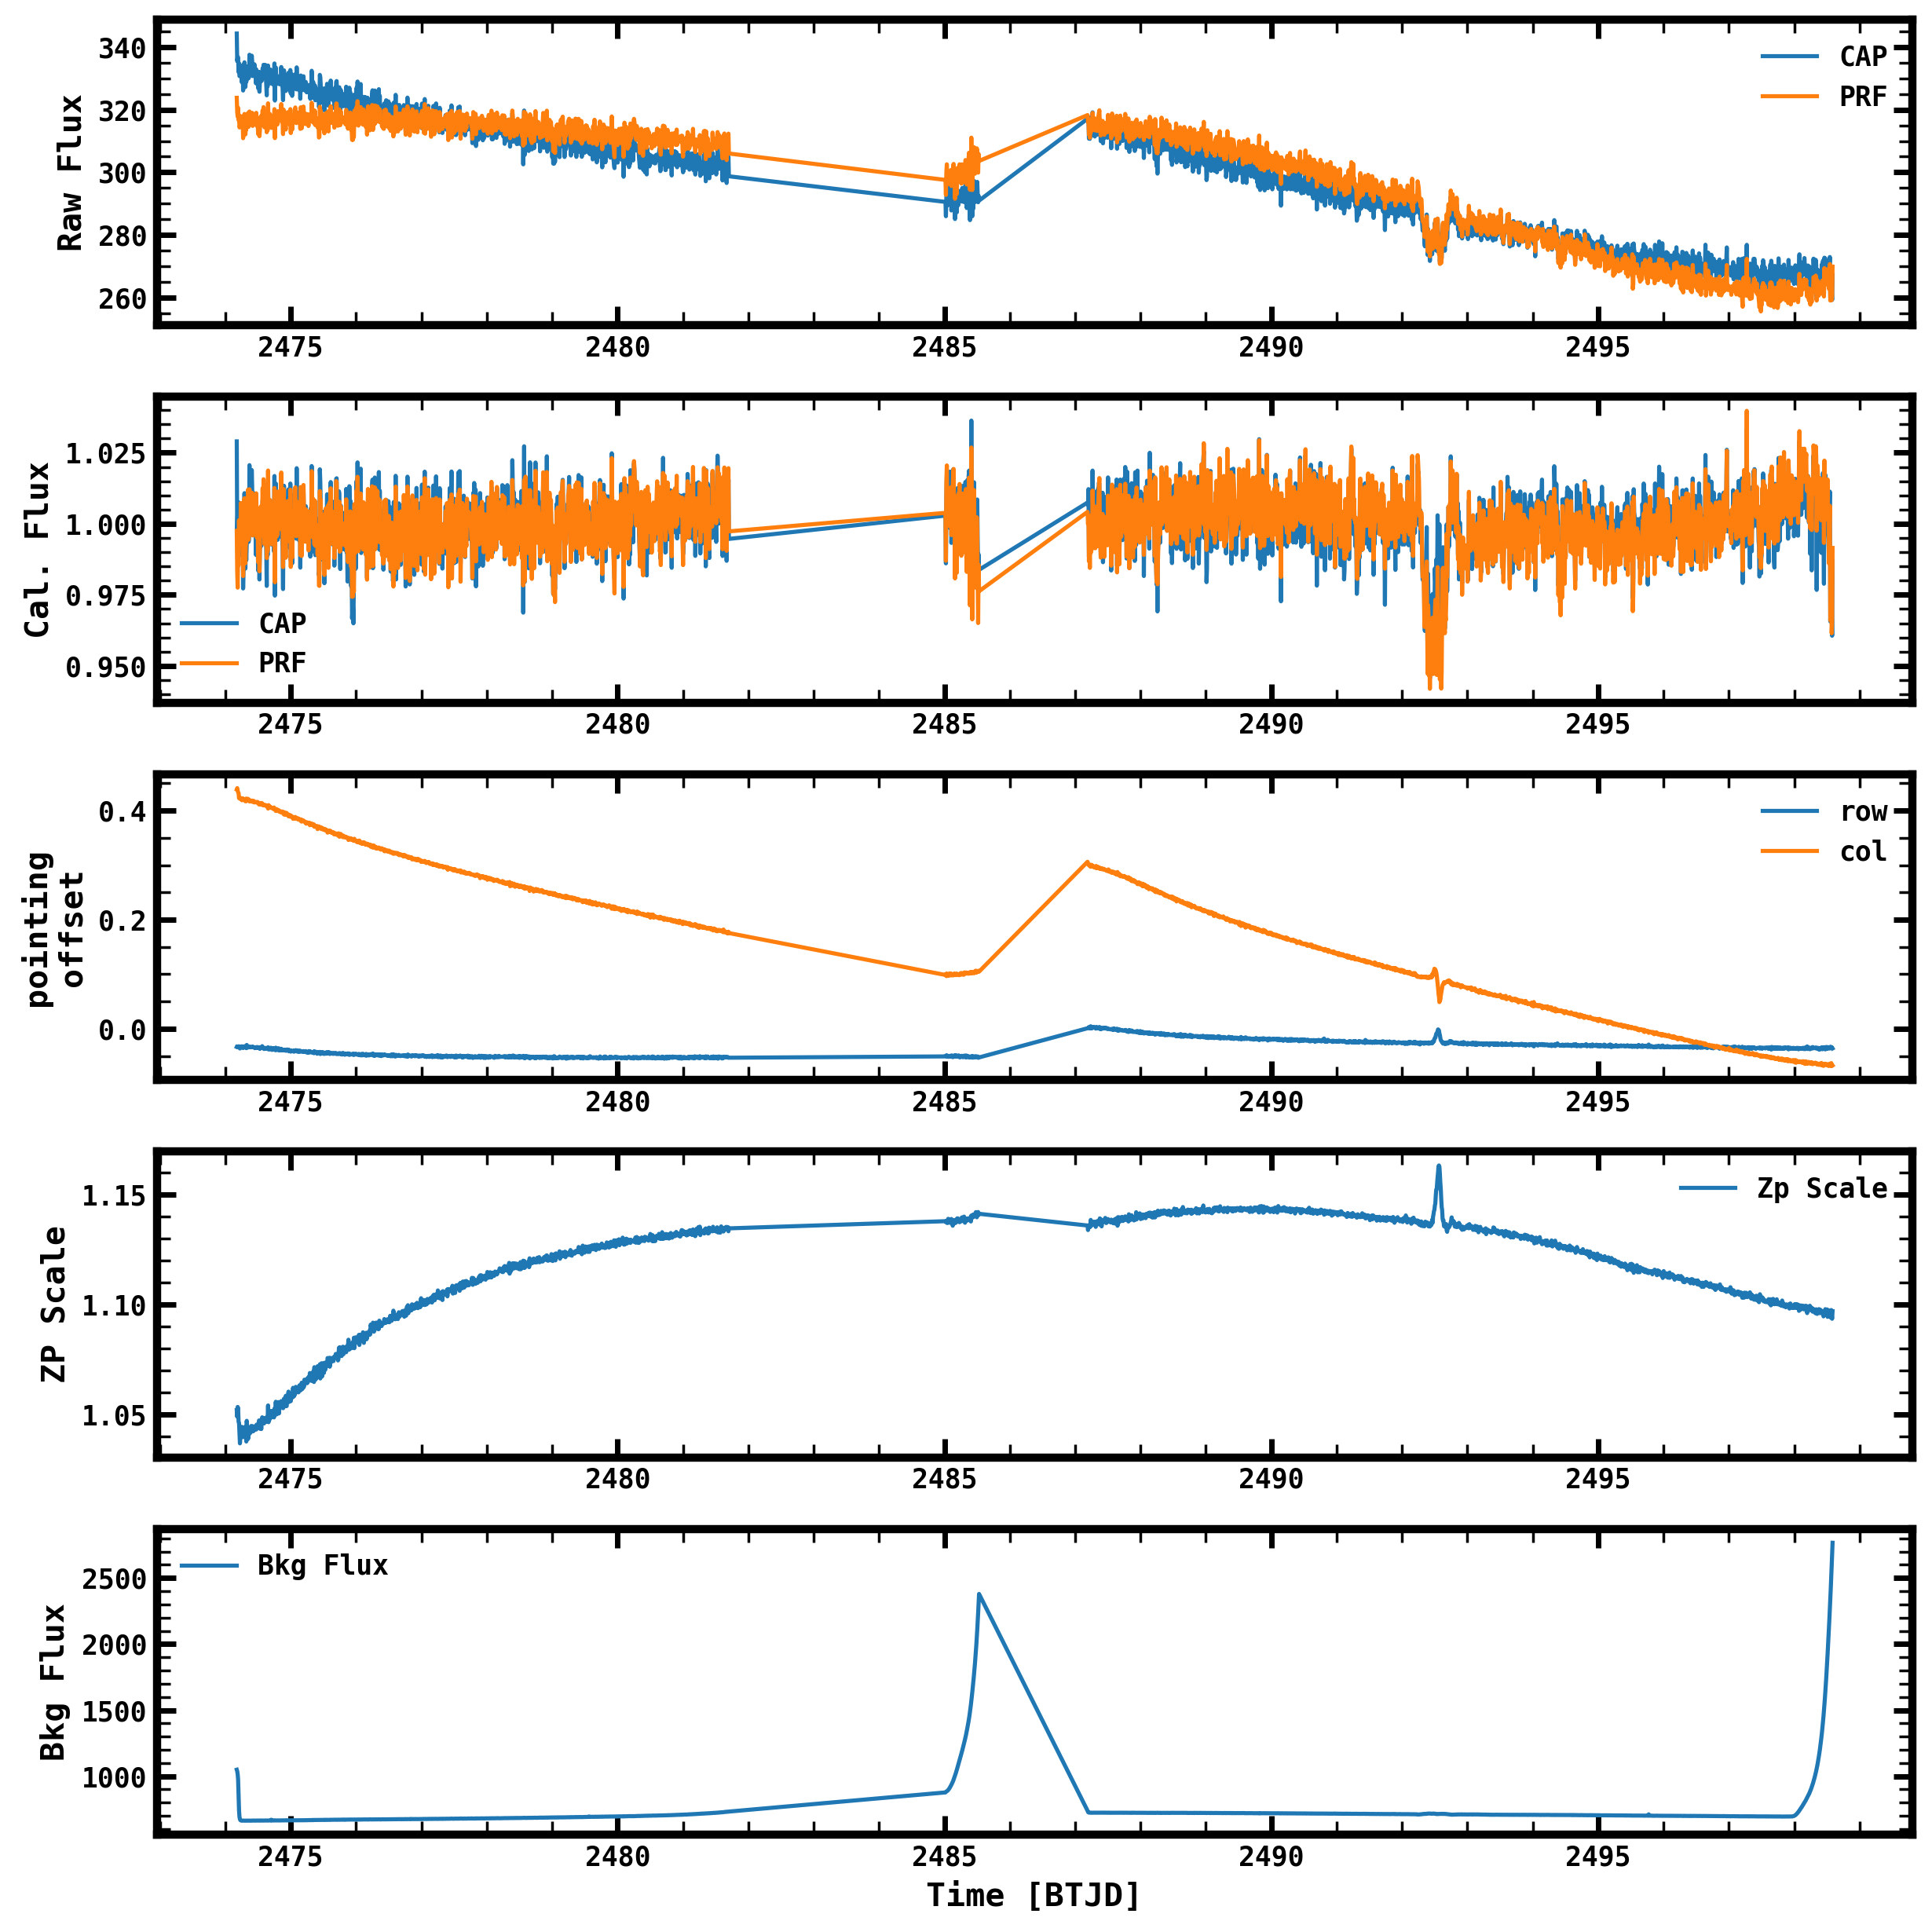

In [7]:
# Check that the Light Curves look okay

plot_lightcurve_and_systematics(light_curves[3])